# The stable road to EIP 1559: Transitioning out of first-price auctions

###### December 2020, [@0x66726564](https://twitter.com/0x66726564) and [@barnabemonnot](https://twitter.com/barnabemonnot)
###### [Robust Incentives Group](https://github.com/ethereum/rig), Ethereum Foundation

---

## TL;DR

- [Pull Request 2924](https://github.com/ethereum/EIPs/pull/2924) in the EIP 1559 repo implements the transition period between the current "legacy" first-price auction-based fee market to 1559 as a soft opt-in for wallets and dapps. **Transactions sent in the legacy format** (with their `gas_price` attribute) **are converted to a 1559-compatible format** (with `gas_premium := max_fee := gas_price`).
- We model the existing fee market where legacy users take price reference from **distributional oracles** (e.g., EthGasStation) to select their gas price. Their behaviour reproduces known patterns of **first-price auctions**: price stickiness and bubbles, due to the oracles' **reflexivity**. Oracles in this setting quote very different prices from the **market-clearing price**, which we estimate at each step.
- On the other hand, **when 1559 users only transact, the oracles closely track the market price**, and more directly the basefee, which these users take as reference to select their transaction parameters.
- This implies that in a mixed regime with both 1559-adapted users (who look at the basefee) and legacy users (who look at price oracles), **the behaviour of 1559 users drives oracles closer to the true market price**. The effect is mixed for legacy users. Although they rely on more precise oracles, we find that their inclusion rates are also worse than 1559-adapted users. Once 1559 is live, we suggest including the current basefee level in oracle estimations to ensure legacy users remain competitive.

---

In this notebook we model and simulate the transition period suggestested in [Pull Request 2924](https://github.com/ethereum/EIPs/pull/2924). In this proposal, while 1559 transactions are expected, legacy-style transactions are still accepted by clients who convert them to 1559 format using default parameters based on the declared gas price.

Under EIP 1559, users are expected to quote their `gas_premium`, the maximum amount received by a miner who includes their transaction, as well as a `max_fee`, which caps the maximum price paid by the user. Meanwhile, current transactions (which we call "legacy" in this notebook) only declare a single `gas_price` parameter, which the user pays in all circumstances (see our general introduction to EIP 1559 and its changes to the existing fee market [here](https://nbviewer.jupyter.org/github/ethereum/rig/blob/master/eip1559/eip1559.ipynb)).

Michał Komorowski analysed for Nethermind the impact of this transition period on the user behaviour [in a notebook](https://nbviewer.jupyter.org/github/NethermindEth/research/blob/main/legacyTransactions.ipynb) using the abm1559 library. His takeaways include a comparison of the average fee paid by legacy users vs 1559 users, as well as their inclusion rates and eviction from the transaction pool. Notably, Michał ends with an important open question:

> `Percent of legacy vs. 1559 users` in the blocks diagrams show us that transactions submitted by all types of users are included in blocks when basefee reaches stablization. It's good. What is very interesting is the fact that around 40% of transactions in blocks (after stablization of basefee) are transactions submitted by naive users. I would expect more transactions from legacy or from clever users and I'm not sure how to exlain this behaviour. It is also worth pointing that in the in the beginning of the simulation, when basefee grows, mainly transactions of clever EIP-1559 users are included in blocks.

We make the hypothesis here that legacy users benefit from the actions of 1559 users, who implicitly align the oracles used by legacy users with the true market price, allowing all users to be included. In this notebook, we'll expand on this idea by comparing two boundary scenarios and their synthesis.

We first import the classes from the [abm1559 library](https://github.com/barnabemonnot/abm1559) we'll use in this notebook. If this is your first notebook, you can also check out the [README](https://github.com/barnabemonnot/abm1559/blob/master/README.md) at the root of this repo for installation details.

In [1]:
%config InlineBackend.figure_format = 'svg'

import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from typing import Sequence, Dict

from abm1559.utils import (
    constants,
    basefee_from_csv_history,
    get_basefee_bounds,
    flatten
)
constants["SIMPLE_TRANSACTION_GAS"] = 210000

from abm1559.txpool import TxPool

from abm1559.users import (
    User1559,
    AffineUser,
    User
)

from abm1559.config import rng

from abm1559.txs import Transaction, Tx1559, TxLegacy

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
    Block
)

from abm1559.simulator import (
    spawn_poisson_heterogeneous_demand,
    update_basefee,
    generate_gbm,
)

import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 1000)
import numpy as np
import time
import seaborn as sns
from tqdm import tqdm

## Simulation components

### Legacy tooling for EIP 1559 environment

We assume that during the transitional period, part of the ecosystem will remain using legacy tooling and creating transactions of the legacy format. To deal with that issue the Pull Request suggests normalising legacy transactions to 1559 transactions using a simple normalisation function.

Whenever a legacy transaction declares some `gas_price`, a 1559 transaction is created with `gas_premium = gas_price` and `max_fee = gas_price`. In other words, `gas_price` is still the fee that the user will pay, but the miner is allowed to receive any fee between `basefee` and `gas_price`.

| Sender | `gas_price` | `gas_premium` | `max_fee` | `basefee` | User pays | Miner receives |
|-|-|-|-|-|-|-|
| Legacy user | 100 | 100 | 100 | 40 | 100 | 60 |
| 1559 user | x | 1 | 100 | 40 | 41 | 1 |

The intuition is that legacy users end up consistently overpaying compared to what 1559 users pay.

We provide now the function casting legacy transactions into the 1559 format.

In [2]:
def normalize_from_legacy(legacy: TxLegacy) -> Tx1559:
    """
    Normalized according to
    https://github.com/ethereum/EIPs/blob/541c8be92fe759aa602b7d06a088ab1a139e37ce/EIPS/eip-1559.md
    """
    normalized_params = {
        "max_fee": legacy.gas_price(),
        "gas_premium": legacy.gas_price(),
        "start_block": legacy.start_block,
    }
    return Tx1559(
        sender=legacy.sender,
        gas_used=constants["SIMPLE_TRANSACTION_GAS"],
        tx_params=normalized_params
    )

Next we introduce Legacy agents with strategic behaviours that are analogous to different gas price estimation methods currently being used.

### Legacy users

Before we are able to simulate the legacy market together with the new proposed 1559 mechanism, we must understand how legacy users will interpret the new environment. We make the assumption that the legacy users live in a world where they are fully unaware that the transition to 1559 took place. They refer to price oracles (given below) for their fee estimation, send transactions that contain their `gas_price` and are oblivious to the current level of the basefee.

In [3]:
MIN_ACCEPTABLE_TIP = 1 * (10 ** 9)
ORACLE_SLOW = "slow"
ORACLE_MEDIUM = "medium"
ORACLE_FAST = "fast"

class LegacyBidder(AffineUser):
    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, cost_per_unit = 0, **kwargs)
        self.value = (1 + self.rng.pareto(2) * 20) * (10 ** 9)

    def percentile(self):
        raise Exception("Not implemented, try using a subclass.")

    def query_oracle(self, env: dict):
        fee_oracles = env["fee_oracles"]
        return fee_oracles[self.oracle()]

    def decide_parameters(self, env: dict):
        gas_price = self.query_oracle(env)
        
        if self.oracle() == ORACLE_SLOW:
            scaling = 0.5
        elif self.oracle() == ORACLE_MEDIUM:
            scaling = 0.75
        else:
            scaling = 0.9
        
        # We add a normal error scaled by the user type
        gas_price += scaling * self.rng.normal() * (10 ** 9)
        
        return {
            "gas_price": int(max(gas_price, MIN_ACCEPTABLE_TIP)), # in wei
            "start_block": self.wakeup_block,
        }
    
    # This function is the main user entry point 
    def create_transaction(self, env: dict):
        tx_params = self.decide_parameters(env)
        
        # If gas price is higher than 1.2 * my value, I balk
        if tx_params["gas_price"] >= 1.2 * self.value:
            return None
        
        tx_params["gas_price"] = min(self.value, tx_params["gas_price"])
                
        tx = TxLegacy(
            sender = self.pub_key,
            gas_used=constants["SIMPLE_TRANSACTION_GAS"],
            tx_params = tx_params,
        )
        return tx

In contrast with previous notebooks, users here do not experience a cost for waiting, so it is set to zero in the `__init__` constructor. We also change the distribution of values, previously a simple uniform distribution over the interval $[1, 20]$ to a [Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution), a.k.a., the 80/20 law (in truth, we use the [Lomax distribution](https://en.wikipedia.org/wiki/Lomax_distribution), which is simply a Pareto distribution shifted to zero, scale it, and shift it again to 1, so that our users have value at least 1 Gwei).

The choice is made to reflect the actual distribution of bids in a more realistic manner, with most users having relatively low value and few users having relatively high value. Note that the scaling of the distribution is rather irrelevant, since we focus on relative differences between users. We scale this distribution to match observed prices on Ethereum and provide intuition. Given here is the distribution of a thousand samples from our value distribution (in Gwei).

array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

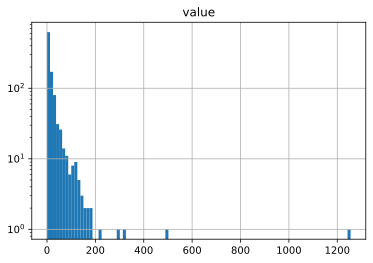

In [4]:
rng = np.random.default_rng(4)
pd.DataFrame({ "value": rng.pareto(2, 1000) * 20 }).hist(log=True, bins = 100)

Note also how our legacy users set their bids.

```python
gas_price = self.query_oracle(env)
gas_price += scaling * self.rng.normal() * (10 ** 9)
```

The `LegacyBidder` user class is subclassed below to define the `query_oracle` method, from which the user obtains their initial estimate of the current price of gas. The oracle is part of the simulation environment, i.e., contained in the `env` vairable.

We then allow the user to modify the price given by this oracle. This increment is returned by a normal distribution, so that the gas price chosen by the user is a noisy version of the quoted oracle price. We represent here the agency of users who tune the gas price themselves taking the oracle as a reference, with most users bidding close to the oracle quote regardless. The normal distribution is scaled by the type of the user, upon which we expand now.

We instantiate three types of users, one for each oracle level ("slow", "medium" and "fast"). Concretely, this represents the different preferences of users faced with the three price levels. We have assumed the cost for waiting of all users to be zero, but we can imagine most users being relatively neutral towards their inclusion speed while few would always hit the fast oracle default for inclusion at maximum speed. The type of the user mirrors their position on this distribution of preferences, with neutral users content to use the "slow" oracle recommendation while hurried users follow the "fast" oracle, and "medium" users in-between.

The observations in this notebook are fairly robust to the levels of these parameters or the proportion of users between these three classes ("slow", "medium" and "fast"), which we'll define later on.

In [5]:
class LegacyBidderSlow(LegacyBidder):
    def oracle(self):
        return ORACLE_SLOW
    
    def export(self):
        return {
            **super().export(),
            "user_type": "user_slow",
        }

class LegacyBidderMedium(LegacyBidder):
    def oracle(self):
        return ORACLE_MEDIUM
    
    def export(self):
        return {
            **super().export(),
            "user_type": "user_medium",
        }

class LegacyBidderFast(LegacyBidder):
    def oracle(self):
        return ORACLE_FAST
    
    def export(self):
        return {
            **super().export(),
            "user_type": "user_fast",
        }

### Price oracles

We use in this notebook a simplified version of the EthGasStation model. Instead of doing a Poisson regression based on confirmation time for a transaction then extracting the percentiles, we just extract the percentiles. Since their quotes are entirely determined by the distribution of gas prices in previous blocks, we call these oracles **distributional**.

Given a window of the `N` most recent blocks, we collect the series of gas prices of all transactions included in these `N` blocks. These gas prices are ordered from lowest to highest and percentiles are extracted. In the example below, suppose we take `N = 1` and blocks include 8 transactions. The percentiles levels are 50 (the median), 75 and 90 respectively for the "slow", "medium" and "fast" oracles.

| Gas prices | Median ("slow" oracle) | 75th-percentile ("medium" oracle) | 90th-percentile ("fast" oracle) |
|-|-|-|-|
| 10, 20, 30, 40, 60, 100, 150, 200 | 50 | 125 | 175 |

This estimation may be biased when blocks aren't full. Suppose a single block includes only a 2000 Gwei transaction, while all other `N-1` blocks are empty. Should our oracles return 2000 Gwei as their estimation of the current market price? Probably not. To avoid such situations, we define the block target as the targetted block size under EIP 1559 and pad empty transaction slots with zeros to ensure oracles return coherent prices.

| Gas prices | Median ("slow" oracle) | 75th-percentile ("medium" oracle) | 90th-percentile ("fast" oracle) |
|-|-|-|-|
| 0, 0, 0, 0, 0, 0, 150, 200 | 0 | 75 | 175 |

In [6]:
def update_oracles(env: dict, block_target: int) -> None:
    blocks_window = len(env["recent_blocks"])
    fees = flatten([[tx.gas_price({ "basefee": block.basefee }) for tx in block.txs] for block in env["recent_blocks"]])
    fees += [0.0] * (blocks_window * block_target - len(fees))

    env["fee_oracles"] = {
        ORACLE_SLOW: np.percentile(fees, 50) if len(fees) > 0 else 0,
        ORACLE_MEDIUM: np.percentile(fees, 75) if len(fees) > 0 else 0,
        ORACLE_FAST: np.percentile(fees, 90) if len(fees) > 0 else 0
    }

### Bidding bots

A special class of high-value users exist on the network too. These users post transactions closing collateralised positions, arbitraging fees on DEXes or bidding for first inclusion. This is where the highest fees are observed, as the largest admissible fee for these transactions is the size of their profit opportunity, which in the three cases mentioned above can be pretty huge. (For more on Miner-Extractable Value, or MEV, and bidding wars, check out [Phil Daian et al., _Flashbots 2.0_ paper](https://arxiv.org/abs/1904.05234)).

Recently, [a lower bound of about 10k out of 443k blocks](https://ethresear.ch/t/flashbots-frontrunning-the-mev-crisis/8251) was estimated to have been used for MEV-related activity, with a large amount of the profits (~18.7%) paid back to the miners who included these high-fee, MEV-extracting transactions. Although the behaviour of bots acting on behalf of MEV-chasing users is complex, involving bidding wars and real-time analysis of the transaction pool, we'll use a simple model of an extremely risk averse user who wants their transaction included at any cost (as long as it is lower than the value it can extract).

The risk-averse user observes the "fast" oracle and posts a gas price somewhere between that oracle and its own (high) value. More data on the outcomes of such bidding wars could be used to tune this assumption, but we reason that any factor such as latency or adverse behaviour may be responsible for stopping the bidding war at any point between its lower bound (the fast oracle) and its upper bound (the user value, i.e., whatever MEV there is to extract).

In [8]:
class RiskAverseLegacyUser(AffineUser):
    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, cost_per_unit = 0, **kwargs)
        self.value = (1 + self.rng.pareto(2) * 40) * (10 ** 9)

    def percentile(self):
        raise Exception("Not implemented, try using a subclass.")

    def decide_parameters(self, env: dict):
        oracle_price = env["fee_oracles"][ORACLE_FAST]
        gas_price = oracle_price + self.rng.random() * (self.value - oracle_price)
        return {
            "gas_price": int(gas_price), # in wei
            "start_block": self.wakeup_block,
        }
    
    # This function is the main user entry point 
    def create_transaction(self, env: dict):
        tx_params = self.decide_parameters(env)
                
        expected_payoff = self.value - tx_params["gas_price"]
        if expected_payoff <= 0:
            return None
        
        tx = TxLegacy(
            sender = self.pub_key,
            gas_used=constants["SIMPLE_TRANSACTION_GAS"],
            tx_params = tx_params,
        )
        return tx
    
    def export(self):
        return {
            **super().export(),
            "user_type": "bidding_bot",
        }

### Transaction and user pools

Mirroring [the work of Michał Komorowski for Nethermind](https://nbviewer.jupyter.org/github/NethermindEth/research/blob/main/legacyTransactions.ipynb), we cap the transaction pool length to represent the bounded memory and computation of mining clients. The transaction pool otherwise still orders transactions by their effective tip (the amount received by the miner from inclusion).

In [9]:
MAX_TRANSACTIONS_IN_POOL = 2000

class MixedTxPool(TxPool):
    
    def add_txs(self, txs: Sequence[Transaction], env: dict) -> None:
        for tx in txs:
            if type(tx) is TxLegacy:
                tx = normalize_from_legacy(tx)
            self.txs[tx.tx_hash] = tx
        
        self.pool_length += len(txs)
            
        if self.pool_length > MAX_TRANSACTIONS_IN_POOL:
            sorted_txs = sorted(self.txs.values(), key = lambda tx: -tx.tip(env))
            self.empty_pool()
            self.add_txs(sorted_txs[0:MAX_TRANSACTIONS_IN_POOL], env)
            return sorted_txs[MAX_TRANSACTIONS_IN_POOL:]
        
        return []
    
    def select_transactions(self, env, user_pool=None, rng=rng):
        # Miner side
        max_tx_in_block = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"])

        valid_txs = [tx for tx in self.txs.values() if tx.is_valid(env) and tx.tip(env) >= MIN_ACCEPTABLE_TIP]
        rng.shuffle(valid_txs)

        sorted_valid_demand = sorted(
            valid_txs,
            key = lambda tx: -tx.tip(env)
        )
        selected_txs = sorted_valid_demand[0:max_tx_in_block]

        return selected_txs

### The market price

Block space allocation is a dynamic process with a queue of users competing for scarce resources. Although first price auctions are an imprecise mechanism to allocate the resources to users efficiently, they provide an estimator of some true **market price**. We define market price as the actual gas price that ought to be quoted to exactly equalise demand with supply. How can we find it in our setting?

We target the inclusion of some number of users $T$ in the block (recall that all users have the same, constant demand for gas). New users come in between each block, while the pool holds at most 10,000 unincluded users, ranked by their tip amount. Before a new block is created, we take a "snapshot" of the current state: a set of new users with values for gas $(v_i)_i$, and a set of pending transactions with gas prices $(g_j)_j$. We now sort the values and gas prices in decreasing order, obtaining a sequence of "prices" $(p_k)_k$. Taking $p_T$, the $T$-th price in the sequence, we estimate the true market price that equalises supply with the demand given the snapshot $(v, g)$.

There are at least two other ways to estimate the true market price.

1. Associate each transaction $j$ in the transaction pool with the user who sent it, and use the value of that user $v_j$ instead of the gas price $g_j$ of the transaction. This is likely a "truer" price of the current market, but it is also not a very useful one. There is nothing the user can do now that they sent their transaction in, so the market must decide to allocate space between existing transactions and the new users.
2. Let new users post their transactions, record the gas prices $(g_i)_i$ of these new transactions and use that instead of the new users' values $(v_i)_i$. This price is the most concrete estimation of the realised market state, but may be biased towards the bidding strategies of new users, since the gas price is in general not equal to the user's value.

In a sense, we look for a value that answers the question: "In a world where the market has full information about user values, which _uniform_ price should the market quote to maximise the amount collected?"

We give in `get_market_price` the implementation of this estimator. Note that when we have less users and transactions than the target amount, the price is set to 0, since there is no scarcity. In practice, we could set this no-scarcity price to the minium fee miners expect from a transaction, although this makes no difference in the following.

In [10]:
def get_market_price(users: Sequence[User], txs: Sequence[Transaction], env: dict, target: int) -> float:
    values = sorted(
        [user.value for user in users] + [tx.gas_price(env) for tx in txs],
        key = lambda v: -v
    )
    return values[target] if target < len(values) else 0

### The main simulation loop

Finally, here is the simulation loop! Most of the lines below should be familiar if you've followed our notebooks until now. If so, don't give it a second thought and skip ahead.

In [18]:
def simulate(demand_scenario, shares_scenario, extra_metrics = None, rng = rng):
    # Instantiate a couple of things
    txpool = MixedTxPool()
    chain = Chain()
    metrics = []
    user_pool = UserPool()
    blocks_window = 30
    start_time = time.time()
    block_target = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"] / 2.0)
    
    # `env` is the "environment" of the simulation
    env = {
        # we start with the historic basefee based on previous txs
        "basefee": constants["INITIAL_BASEFEE"],
        # "basefee": initial_historic_basefee,
        "current_block": None,
        "min_premium": 2 * (10 ** 9),
        "recent_blocks": [],
        "fee_oracles": {
            ORACLE_SLOW: 2 * (10 ** 9),
            ORACLE_MEDIUM: 2 * (10 ** 9),
            ORACLE_FAST: 2 * (10 ** 9)
        }
    }

    for t in tqdm(range(len(demand_scenario))):
        # Sets current block
        env["current_block"] = t
        
        # Reset the random number generator with new seed to generate users with same values across runs
        rng = np.random.default_rng(t)
        
        ### SIMULATION ###

        # We return some demand which on expectation yields `demand_scenario[t]` new users per round
        users = spawn_poisson_heterogeneous_demand(t, demand_scenario[t], shares_scenario[t], rng=rng)
        
        # Record the market price given the current snapshot
        market_price = get_market_price(
            users,
            txpool.txs.values(),
            env,
            block_target
        )

        # Add new users to the pool
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, env)

        # New transactions are added to the transaction pool
        # `evicted_txs` holds the transactions removed from the pool for lack of space
        evicted_txs = txpool.add_txs(decided_txs, env)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(env)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(
            txs = selected_txs, parent_hash = chain.current_head,
            height = t, basefee = env["basefee"]
        )
        env["recent_blocks"] = env["recent_blocks"][-(blocks_window-1):] + [block]
        
        # Record the min premium in the block
        env["min_premium"] = block.min_premium()
        
        # The block is added to the chain
        chain.add_block(block)
        
        ### METRICS ###
                
        row_metrics = {
            "block": t,
            "users": len(users),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "basefee": env["basefee"] / (10 ** 9), # to Gwei
            "slow_oracle": env["fee_oracles"][ORACLE_SLOW] / (10 ** 9), # to Gwei
            "medium_oracle": env["fee_oracles"][ORACLE_MEDIUM] / (10 ** 9), # to Gwei
            "fast_oracle": env["fee_oracles"][ORACLE_FAST] / (10 ** 9), # to Gwei
            "market_price": market_price  / (10 ** 9), # to Gwei
            "blk_min_premium": block.min_premium() / (10 ** 9), # to Gwei
            "blk_max_premium": block.max_premium() / (10 ** 9), # to Gwei
            "blk_min_tip": block.min_tip(env) / (10 ** 9), # to Gwei
            "blk_max_tip": block.max_tip(env) / (10 ** 9), # to Gwei
        }
        
        if not extra_metrics is None:
            row_metrics = {
                **row_metrics,
                **extra_metrics(env, users, user_pool, txpool),
            }
        
        metrics.append(row_metrics)

        ### ORACLES ###
        
        update_oracles(env, block_target)
        
        # Finally, basefee is updated and a new round starts
        env["basefee"] = update_basefee(block, env["basefee"])

    return (pd.DataFrame(metrics), user_pool, chain)

## Boundary cases: all legacy and all 1559 users

The simulation loop above defines a 1559-environment. There is a basefee determining transaction validity and blocks are created with 1559-formatted transactions (with `max_fee` and `gas_premium` fields). In this environment, we start by looking at two scenarios.

1. In the first, we only have legacy users posting transactions in this 1559-environment. Legacy users are unaware of the presence of a basefee. They produce their transactions using the oracles as their sole source of market information. The transactions are legacy-formatted, setting the `gas_price` field to the amount desired by the user.
2. In the second, we simulate 1559 users as we have done in previous notebooks, e.g., [Strategic users in 1559](https://nbviewer.jupyter.org/github/barnabemonnot/abm1559/blob/master/notebooks/strategicUser.ipynb). These users know about the basefee and use its current value to produce their transactions, which contain `max_fee` and `gas_premium` attributes.

Before launching into these scenarios, we discuss the demand process in this notebook.

### Generating the demand

In previous notebooks, we've always used a stationary demand to simulate the behaviour of the mechanism. This is a good assumption to obtain the stationary behaviour of the basefee and 1559 users, but is obviously a gross simplification of the real world. Demand can be made non-stationary in two ways:

1. The amount of new users is drawn from a different distribution each step.
2. User values change over time.

While 2. is a probably a better representation of systemic shocks (e.g., introduction of a new token or contract), 1. appears to reflect better more natural chain activity, with high and low demand regimes. This is the choice we make in this notebook.

We generate a sample path from a geometric Brownian motion (GBM) with $\mu = \frac{\sigma^2}{2}$ to remove any trend. The path has some value $d_t$ at each time step $t$. We then sample from a Poisson distribution of mean $d_t$ to obtain the actual number of users spawned at time step $t$. Note that $d_t$ may be a decimal number, but the Poisson sample will always be integer-valued.

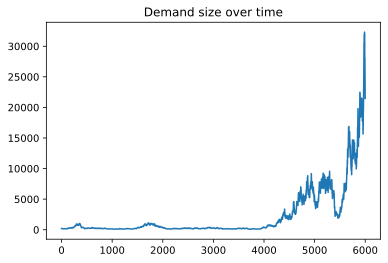

In [19]:
blocks = 6000

rng = np.random.default_rng(4)
sigma = 0.05
mu = 0.5 * sigma**2
gbm = list(generate_gbm(200, blocks, paths=1, mu=mu, sigma=sigma, rng=rng).flatten())

# Plot demand
f = plt.figure()
plt.title('Demand size over time', color='black')
plt.plot(range(blocks), gbm)
plt.show()

### Scenario 1: All legacy users

In this scenario, only legacy users interact in a 1559-environment. We instantiate constant fractions of each user type each step, while the absolute number of users follows the demand process generated by the GBM sample path.

In particular, following a rough intuition of Pareto-law distributed users, we imagine that most users have relatively low hurry, while some users are willing to pay greater amounts for faster inclusion. This assumption is implemented with the following shares of user types:

In [20]:
def extra_metrics_fpa(env, users, user_pool, txpool):
    pool_legacy_users = len(
        [tx for tx in txpool.txs.values() if isinstance(user_pool.users[tx.sender], LegacyBidder)])

    return {
        "legacy": len([user for user in users if isinstance(user, LegacyBidder)]),
        "pool_legacy": pool_legacy_users
    }

# Number of new users per time step
demand_scenario = [gbm[t] for t in range(6000)]

# Shares of new users per time step
shares_scenario_fpa = [{
    LegacyBidderSlow: 0.50,
    LegacyBidderMedium: 0.30,
    LegacyBidderFast: 0.15,
    RiskAverseLegacyUser: 0.05,
} for t in range(blocks)]

In [21]:
(df, user_pool, chain) = simulate(demand_scenario, shares_scenario_fpa, extra_metrics_fpa)

100%|██████████| 6000/6000 [06:59<00:00, 14.31it/s] 


<AxesSubplot:xlabel='block'>

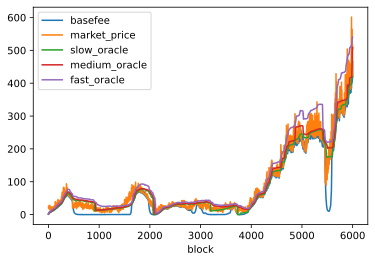

In [23]:
df.plot("block", ["basefee", "market_price", "slow_oracle", "medium_oracle", "fast_oracle"])

#### Atrocity exhibition I: Sticky oracles

Let's zoom in on a particularly interesting pattern.

<AxesSubplot:xlabel='block'>

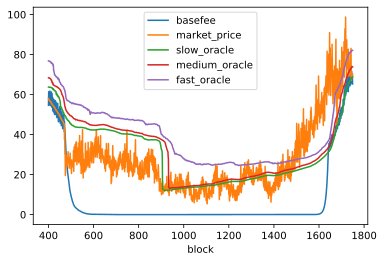

In [24]:
df[(df.block >= 400) & (df.block < 1750)].plot("block", ["basefee", "market_price", "slow_oracle", "medium_oracle", "fast_oracle"])

Past block 400, demand decreases, basefee does too, yet the oracles stubbornly quote a much higher price. We explain this strange situation in the following way:

1. Legacy users observe the oracles, _not_ the basefee. Seeing that the price is high, most low-value users get discouraged and do not submit.
2. The transaction pool empties quickly, as both the high and low value users it accumulated over time get included. The basefee is low, there is no reason not to include transactions from the pool, while most new users are discouraged by the high oracle prices. The inclusion of users in the pool slightly lowers the oracle levels, but not quite enough to decide low value users to join.

<AxesSubplot:xlabel='block'>

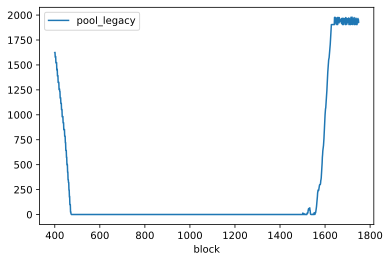

In [26]:
df[(df.block >= 400) & (df.block < 1750)].plot("block", ["pool_legacy"])

3. For some time, the pool is empty, most new users are discouraged so blocks which aren't full keep the basefee at zero, while the oracles quote the prices observed in the latest blocks. These prices are sufficiently high to keep the oracles high, underscoring the reflexivity of the distribution-based oracles.
4. A turning point is reached around block 900, as demand decreases significantly. There are now few users with value matching the price quoted by the oracles (most are still discouraged). Blocks are increasingly empty, inducing a sudden drop of the "slow" oracle which tracks the median fee included in recent blocks.
5. Seeing a low oracle price, the `LegacyBidderSlow` users who use the "slow" oracle as their price reference resume sending their transactions, no longer discouraged.
6. The same phenomenon occurs for the medium and fast oracles, with some delay since they track higher percentiles of the recent fee distribution.
7. The basefee was in the doldrums, hovering close to its minimum value. Now that all the oracles are a go and demand is picking up again, blocks fill up and the basefee trends upwards once again.

This pattern is important to understand some of the failings of first-price auctions. **Strategic behaviour of bidders in FPAs tends to possess some amount of reflexivity: I will bid high if I believe you will too. Oracles do not come to dispel this reflexivity, in fact, they may amplify it by focusing on the observed distribution of bids: as long as they see everyone bidding high, they'll quote a high price. This clearly induces some stickiness to prices, even after demand conditions have shifted and a lower price overall could clear the market.**

Obviously, this simulation is still a toy model. We do not have real data on how the basefee would interact with an FPA-based market, but the results above clue us in regarding its behaviour. When the disconnect between oracle prices and true market price is in effect, we should expect an opposite reaction of the basefee. While oracles overquote the current price, the basefee would stay low given the low inclusion rate of users who are mostly discouraged.

#### Atrocity exhibition II: Bubbly oracles

We've already observed the stickiness of distributional oracles in the previous exhibit, where oracles become disconnected from the true market-clearing price. It's interesting to focus here on the conditions when there is also a disconnect _between oracles_ themselves.

Consider the following plot.

<AxesSubplot:xlabel='block'>

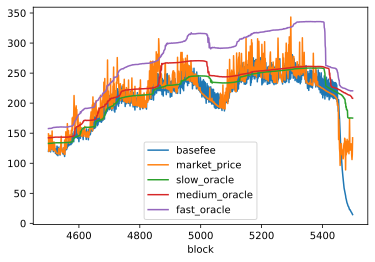

In [27]:
df[(df.block >= 4500) & (df.block < 5500)].plot("block", ["basefee", "market_price", "slow_oracle", "medium_oracle", "fast_oracle"])

The `fast` oracle clearly hovers above everyone else, reaching maximum difference with the two other oracles right before a demand dip. Although we've included only 5% of bidding bots, their behaviour is enough to tilt the highest percentile-tracking oracle to a distinct behaviour.

In [28]:
# Obtain the pool of users (all users spawned by the simulation)
user_pool_df = user_pool.export().rename(columns={ "pub_key": "sender" })

# Export the trace of the chain, all transactions included in blocks
chain_df = chain.export()

# Join the two to associate transactions with their senders
user_txs_df = chain_df.join(user_pool_df.set_index("sender"), on="sender")

<AxesSubplot:xlabel='block_height'>

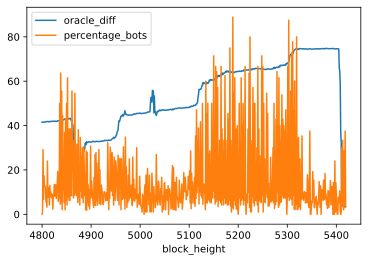

In [29]:
txs_per_user_type = user_txs_df.groupby(
    ["block_height", "user_type"]
).agg(
    { "user_type": len }
).unstack(level=-1).reset_index()
txs_per_user_type["user_type"] = txs_per_user_type["user_type"].fillna(0)
txs_per_user_type.columns = [
    "block_height", "bidding_bot", "user_fast", "user_medium", "user_slow"
]
txs_per_user_type["total"] = txs_per_user_type.apply(
    lambda row: row.bidding_bot + row.user_fast + row.user_medium + row.user_slow,
    axis = 1
)
txs_per_user_type["percentage_bots"] = txs_per_user_type.apply(
    lambda row: row.bidding_bot / row.total * 100,
    axis = 1
)
txs_per_user_type["fast_oracle"] = df["fast_oracle"]
txs_per_user_type["medium_oracle"] = df["medium_oracle"]
txs_per_user_type["oracle_diff"] = txs_per_user_type["fast_oracle"] - txs_per_user_type["medium_oracle"]
txs_per_user_type.iloc[range(4800, 5420)].plot("block_height", ["oracle_diff", "percentage_bots"])

We plot in blue the price difference between the `fast` oracle and the `medium` oracle, in Gwei. In orange we have the proportion of bidding bots included in the block. We spawn about 5% of bidding bots each step, but observe often a much higher proportion of them included in each block. Since these users have higher value, they are indeed more likely to be included. With their high fees, they push the fast oracle price up faster than the medium oracle moves.

### Scenario 2: All 1559 users

In this scenario, we reproduce the situation analysed in [Strategic users in 1559](https://nbviewer.jupyter.org/github/barnabemonnot/abm1559/blob/master/notebooks/strategicUser.ipynb). We have two types of users:

- `OptimisticUser`: simply takes the basefee plus the minimum miner premium as their bid.
- `StrategicUser`: takes the basefee plus the minimum premium observed in the previous block, plus a small increment to outbid other users.

As we've seen in the [Strategic users in 1559](https://nbviewer.jupyter.org/github/barnabemonnot/abm1559/blob/master/notebooks/strategicUser.ipynb) notebook, strategic users are competitive in times of large upward demand shifts (when basefee is "excessively low", in the terms of [Tim Roughgarden's report](http://timroughgarden.org/papers/eip1559.pdf)), but their outbidding is irrelevant otherwise.

In [30]:
class OptimisticUser(User1559):
    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, cost_per_unit = 0, **kwargs)
        self.value = (1 + self.rng.pareto(2) * 20) * (10 ** 9)
        
    def create_transaction(self, env):
        tx = super().create_transaction(env)
        if not tx is None:
            tx.gas_used = constants["SIMPLE_TRANSACTION_GAS"]
        return tx

class StrategicUser(User1559):
    """
    A strategic affine user sending 1559 transactions.

    - Expects to be included in the next block
    - Prefers not to participate if its expected payoff is negative
    - Strategic gas_premium
    """

    epsilon = 0.1 # how much the user overbids by

    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, cost_per_unit = 0, **kwargs)
        self.value = (1 + self.rng.pareto(2) * 20) * (10 ** 9)

    def decide_parameters(self, env):
        if env["min_premium"] is None:
            min_premium = 1 * (10 ** 9)
        else:
            min_premium = env["min_premium"]

        gas_premium = min_premium + self.epsilon * (10 ** 9)
        max_fee = self.value

        return {
            "max_fee": max_fee, # in wei
            "gas_premium": gas_premium, # in wei
            "start_block": self.wakeup_block
        }
    
    def create_transaction(self, env):
        tx = super().create_transaction(env)
        if not tx is None:
            tx.gas_used = constants["SIMPLE_TRANSACTION_GAS"]
        return tx

    def export(self):
        return {
            **super().export(),
            "user_type": "strategic_user_1559",
        }

    def __str__(self):
        return f"1559 strategic affine user with value {self.value} and cost {self.cost_per_unit}"

Let's simulate!

In [31]:
def extra_metrics_1559(env, users, user_pool, txpool):
    pool_strat_users = len(
            [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) is StrategicUser])
    pool_nonstrat_users = len(
            [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) is OptimisticUser])
    return {
        "strategic": len([user for user in users if type(user) is StrategicUser]),
        "nonstategic": len([user for user in users if type(user) is OptimisticUser]),
        "pool_strategic": pool_strat_users,
        "pool_nonstrat": pool_nonstrat_users,
    }

# Number of new users per time step
demand_scenario = [gbm[t] for t in range(6000)]

# Shares of new users per time step
shares_scenario_1559 = [{
    StrategicUser: 0.50,
    OptimisticUser: 0.50,
} for t in range(blocks)]

In [32]:
(df_1559, user_pool_1559, chain_1559) = simulate(demand_scenario, shares_scenario_1559, extra_metrics_1559)

100%|██████████| 6000/6000 [12:10<00:00,  8.21it/s]  


We plot the recorded basefee, computed market price and the three oracles over the simulation run.

<AxesSubplot:xlabel='block'>

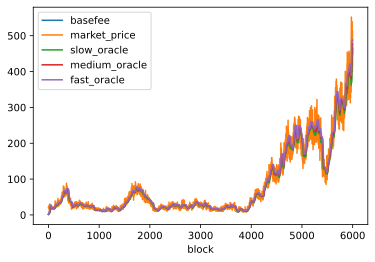

In [33]:
df_1559.plot("block", ["basefee", "market_price", "slow_oracle", "medium_oracle", "fast_oracle"])

Everything moves in lockstep! The basefee adjusts the realised demand to fit the available block space, the way it's supposed to do. Let's zoom in on a small area.

<AxesSubplot:xlabel='block'>

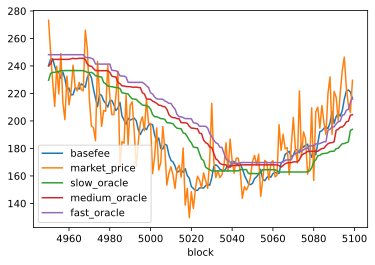

In [34]:
df_1559[(df_1559.block >= 4950) & (df_1559.block < 5100)].plot("block", ["basefee", "market_price", "slow_oracle", "medium_oracle", "fast_oracle"])

It is not completely evident, but we can observe a small amount of lag between the basefee and the market price, as well as between the oracles and the market price.

- When demand decreases and the market-clearing price does too, basefee catches up with some delay. Between blocks 4980 and 5020, it is slightly above the market price. The market price is very much the target of the basefee update rule, so any movement of the first is followed by a slightly laggy response of the other.
- Meanwhile, oracles are even more laggy. We've seen in Scenario 1 that oracles are inherently reflexive, and that their price levels have strong inertia. While the market price falls, oracles stick to their previous level for some time before naturally following downwards.

Despite these small differences, it is clear that the introduction of basefee in agent strategies has implicitly pulled the oracles towards more precise estimations of the true market price. We give the root mean square error (RMSE) between the series of 90-th percentile oracle ("fast") and the market price below. The RMSE measures the distance between two series of data, with an RMSE of zero where the series are equal at each point. We find the RMSE in scenario 2 is lower than that of scenario 1.

We also provide the mean bias error (MBE). A positive mean bias error would indicate that users (at least those who choose the fast oracle for their estimation) tend to overpay compared to the true market price, in line with the popular wisdon that FPAs induce overpaying. Although we find a positive MBE here, more simulations may be required to assert that this is a significant pattern.

In [35]:
rmse_1559 = np.linalg.norm(df_1559["fast_oracle"] - df_1559["market_price"])
rmse_fpa = np.linalg.norm(df["fast_oracle"] - df["market_price"])
mbe_1559 = np.mean(df_1559["fast_oracle"] - df_1559["market_price"])
mbe_fpa = np.mean(df["fast_oracle"] - df["market_price"])

pd.DataFrame({
    "Scenario": ["All legacy users", "All 1559 users"],
    "RMSE": [rmse_fpa, rmse_1559],
    "MBE": [mbe_fpa, mbe_1559]
})

,Scenario,RMSE,MBE
0,All legacy users,2809.718728,20.846171
1,All 1559 users,1321.795814,3.982462


## Final boss: Legacy and 1559 users

We now investigate the more realistic scenario of having some users operating with 1559-adapted tooling, while some keep on with legacy transactions tooling. We simulate here 50% of users on each side, although we expect most users to have 1559-ready tools by the time of the launch (wallets and dapps).

In [36]:
def extra_metrics_mixed(env, users, user_pool, txpool):
    return {
        **extra_metrics_fpa(env, users, user_pool, txpool),
        **extra_metrics_1559(env, users, user_pool, txpool),
    }

# Number of new users per time step
demand_scenario = [gbm[t] for t in range(6000)]

share_1559 = 0.5

# Shares of new users per time step
shares_scenario_mixed = [{
    **{ key: (1-share_1559) * share for key, share in shares_scenario_fpa[0].items() },
    **{ key: share_1559 * share for key, share in shares_scenario_1559[0].items() },
} for t in range(blocks)]

In [37]:
(df_mixed, user_pool_mixed, chain_mixed) = simulate(demand_scenario, shares_scenario_mixed, extra_metrics_mixed)

100%|██████████| 6000/6000 [13:20<00:00,  7.50it/s]   


<AxesSubplot:xlabel='block'>

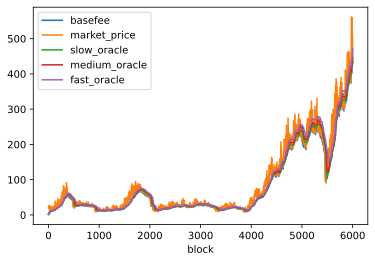

In [38]:
df_mixed.plot("block", ["basefee", "market_price", "slow_oracle", "medium_oracle", "fast_oracle"])

**The introduction of 1559-operating users, who use the basefee as their bidding reference, has tamed the disconnect between distributional oracles and true market price.** We can verify this with another round of metrics.

In [39]:
rmse_mixed = np.linalg.norm(df_mixed["fast_oracle"] - df_mixed["market_price"])
mbe_mixed = np.mean(df_mixed["fast_oracle"] - df_mixed["market_price"])

pd.DataFrame({
    "Scenario": ["All legacy users", "Legacy and 1559 users", "All 1559 users"],
    "RMSE": [rmse_fpa, rmse_mixed, rmse_1559],
    "MBE": [mbe_fpa, mbe_mixed, mbe_1559]
})

,Scenario,RMSE,MBE
0,All legacy users,2809.718728,20.846171
1,Legacy and 1559 users,1463.197018,-0.304276
2,All 1559 users,1321.795814,3.982462


As expected the distance between the oracle and the true market price is bounded between the two benchmark cases we've looked at.

### Inclusion statistics for user types

In the following, we exhibit details on inclusion delay for the 6 user types in our simulation, as well as average gas price paid and waiting time.

In [40]:
# Obtain the pool of users (all users spawned by the simulation)
user_pool_mixed_df = user_pool_mixed.export().rename(columns={ "pub_key": "sender" })

# Export the trace of the chain, all transactions included in blocks
chain_mixed_df = chain_mixed.export()

# Join the two to associate transactions with their senders
user_txs_mixed_df = chain_mixed_df.join(user_pool_mixed_df.set_index("sender"), on="sender")

In [41]:
user_txs_mixed_df["gas_price"] = user_txs_mixed_df.apply(
    lambda row: row.tx.gas_price({ "basefee": row.basefee * (10 ** 9) }) / (10 ** 9),
    axis=1
)
user_txs_mixed_df["waiting_time"] = user_txs_mixed_df["block_height"] - user_txs_mixed_df["wakeup_block"]

In the mixed simulation, users are spawned in unequal ratios, according to the following distribution:

| User | Share |
|-|-|
| (1559) Optimistic | 25% |
| (1559) Strategic | 25% |
| (FPA) Slow oracle follower | 25% |
| (FPA) Medium oracle follower | 15% |
| (FPA) Fast oracle follower | 7.5% |
| (FPA) Bidding bot | 2.5% |

Since all user values are drawn from the same distribution (except for bidding bots), we can check how each user type performs by comparing the shares above with the realised shares of users in each block. For instance, if we consistently observe strategic users occupying 40% of block space, we can say these users overperform.

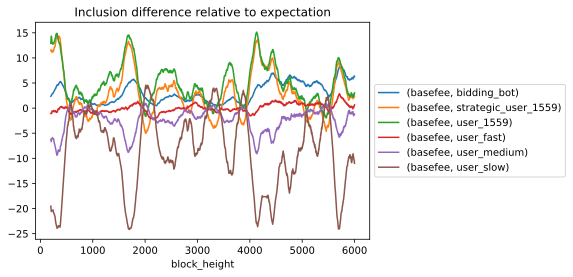

In [42]:
counts_df = user_txs_mixed_df[["block_height", "user_type", "basefee"]].groupby(
    ["block_height", "user_type"]
).count().unstack().fillna(0)
counts_df["total"] = sum([counts_df.iloc[:,i] for i in range(6)])
for i in range(6):
    counts_df.iloc[:,i] = counts_df.iloc[:,i] / counts_df["total"] * 100
expected_percent = [2.5, 25, 25, 7.5, 15, 25]
for i in range(6):
    counts_df.iloc[:,i] = counts_df.iloc[:,i] - expected_percent[i]
    
f = plt.figure()

plt.title('Inclusion difference relative to expectation', color='black')
counts_df.iloc[:,0:6].rolling(window=200).mean().plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Note that we took a rolling average above to smooth out the noise. We observe a consistently positive difference between the realised and the expected share of 1559 users included in blocks, while we see a negative difference for slow and medium oracle followers (fast oracle followers hover around 0, meaning that neither underperform not overperform).

Although the casting rule to convert legacy transactions to 1559 transactions seems to favour legacy users who potentially offer their whole bid to the miner, the result above points to the contrary. The basefee is the true determinant of transaction inclusion, with 1559 users better able to "ride out" basefee fluctuations. Legacy users base their price estimation on the oracle levels, which do not track the basefee directly but the bids of previous users. This is visible too with the following plot which tracks the average gas price paid by each user type over time.

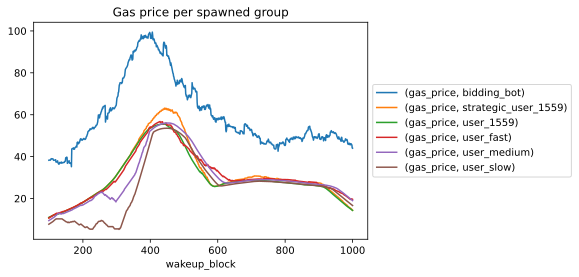

In [43]:
f = plt.figure()

plt.title('Gas price per spawned group', color='black')
user_txs_mixed_df[
    (user_txs_mixed_df.wakeup_block <= 1000)
][["wakeup_block", "user_type", "gas_price"]].groupby(
    ["wakeup_block", "user_type"]
).mean().unstack().fillna(0).rolling(window=100).mean().plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

To provide a fair comparison, we compute the average gas price paid for all users spawned at the same time, rather than all users included in the same block. We also zoom in on a representative part of the plot. We unsurprisingly observe higher gas prices for bidding bots, but also notice higher gas prices for 1559 users than for FPA, more so when demand and prices are increasing.

We note too that legacy users tend to wait for a longer amount of time before inclusion. Legacy users who underbid initially and are priced out by the higher basefee wait until price levels come down and their bid becomes valid again.

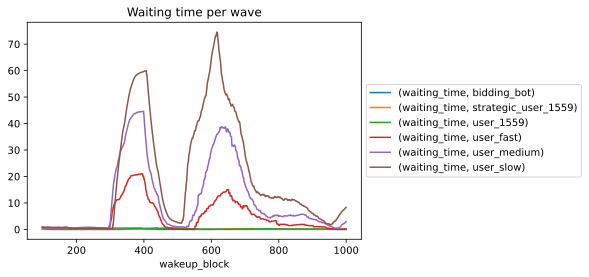

In [44]:
f = plt.figure()

plt.title('Waiting time per wave', color='black')
user_txs_mixed_df[
    (user_txs_mixed_df.wakeup_block <= 1000)
][["wakeup_block", "user_type", "waiting_time"]].groupby(
    ["wakeup_block", "user_type"]
).mean().unstack().fillna(0).rolling(window=100).mean().plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

All this presents an issue for the transition as currently envisioned. Legacy users would consistently underestimate the inclusion price, especially when demand increases and the basefee with it, by basing their bids on the reported oracle levels. To alleviate this concern, **it may be necessary for FPA oracles to include the current basefee level in their price estimations**.

---

## (Bonus) How much improvement do 1559 users bring?

We reuse the code of the mixed simulation and vary the `share_1559` parameter to get a sense of the impact of basefee-reasoning users.

In [45]:
# Number of new users per time step
demand_scenario = [gbm[t] for t in range(6000)]
rmses = []

for share_1559 in np.arange(0, 1, 0.1):
    # Shares of new users per time step
    shares_scenario_mixed = [{
        **{ key: (1-share_1559) * share for key, share in shares_scenario_fpa[0].items() },
        **{ key: share_1559 * share for key, share in shares_scenario_1559[0].items() },
    } for t in range(blocks)]

    (df_mixed, user_pool_mixed, chain_mixed) = simulate(demand_scenario, shares_scenario_mixed)
    
    rmse_mixed = np.linalg.norm(df_mixed["fast_oracle"] - df_mixed["market_price"])
    rmses += [rmse_mixed]

100%|██████████| 6000/6000 [18:24<00:00,  5.43it/s]    


<AxesSubplot:xlabel='share_1559'>

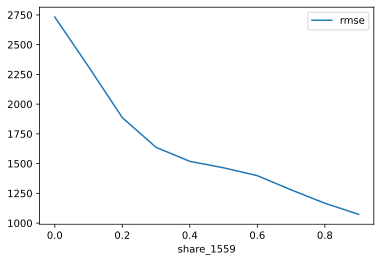

In [46]:
pd.DataFrame({
    "share_1559": np.arange(0, 1, 0.1),
    "rmse": rmses
}).plot("share_1559", "rmse")

There is already a steep reduction in the distance between the true market price and the 90th-percentile oracle with 20% of 1559 users in the mix!